In [8]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from torchvision.models import VGG16_Weights
from PIL import Image

In [9]:
# 1. SETUP DAN TRANSFORMASI DATA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

data_dir = "/kaggle/input/spoonvsfork"

# Transformasi untuk data training (dengan augmentasi)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformasi untuk data testing (tanpa augmentasi)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Menggunakan device: cuda


In [10]:
# 2. LOAD DATASET DAN SPLIT
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Tentukan rasio untuk split validasi
val_percent = 0.2
val_size = int(len(full_dataset) * val_percent)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Gunakan transform test untuk dataset validasi
val_dataset.dataset.transform = test_transform

# Buat DataLoader untuk iterasi data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Dapatkan nama-nama kelas
class_names = full_dataset.classes
print("Nama-nama kelas:", class_names)

Nama-nama kelas: ['spoon-vs-fork']


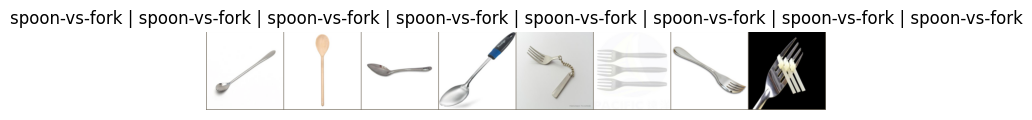

In [11]:
# 3. VISUALISASI SAMPEL GAMBAR
def imshow(img, title):
    # Un-normalisasi gambar
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Dapatkan satu batch data untuk visualisasi
data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:8]), title=' | '.join([class_names[i] for i in labels[:8]]))

In [12]:
# 4. LOAD MODEL VGG16
# Load model VGG16 dengan bobot pra-terlatih
model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# Freeze parameter model kecuali classifier layer
for param in model.parameters():
    param.requires_grad = False

# Ganti classifier layer untuk tugas klasifikasi biner (2 kelas)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)

# Pindahkan model ke device yang ditentukan
model = model.to(device)

Epoch [1/20], Train Loss: 0.0760, Val Loss: 0.0010
Epoch [2/20], Train Loss: 0.0002, Val Loss: 0.0004
Epoch [3/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [4/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [5/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [6/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [7/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [8/20], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [9/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [10/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [11/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [12/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [13/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [14/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [15/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [16/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [17/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [18/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [19/20], Train Loss: 0.0001, Val Loss: 0.0002
Epoch [20/20], Train 

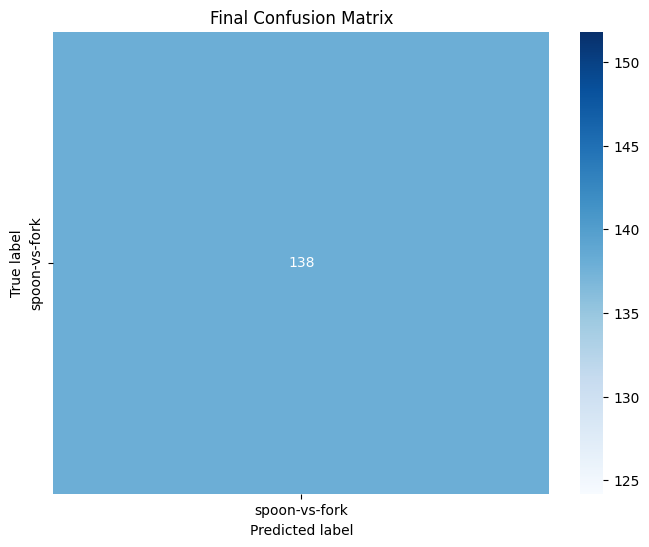

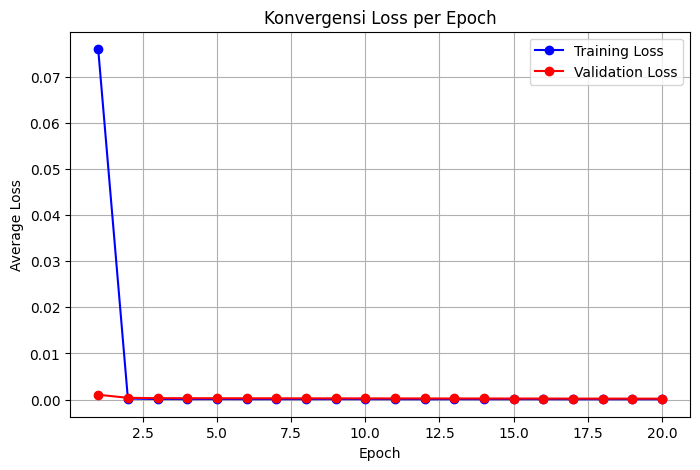

In [13]:
# 5. TRAINING DAN EVALUASI
# Loss dan Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=3)
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for val_images, val_labels_batch in val_loader:
            val_images = val_images.to(device)
            val_labels_batch = val_labels_batch.to(device).float().unsqueeze(1)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            preds = torch.sigmoid(val_outputs).cpu().numpy() > 0.5
            all_preds.extend(preds.flatten().tolist())
            all_labels.extend(val_labels_batch.cpu().numpy().flatten().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping diaktifkan!")
        break

# Hitung dan visualisasikan confusion matrix
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"\nFinal Validation Accuracy: {acc*100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Final Confusion Matrix")
plt.show()

# VISUALISASI LOSS KONVERGEN
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='red', label='Validation Loss')
plt.title("Konvergensi Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.show()

Prediksi: spoon-vs-fork (Confidence: 99.99%)


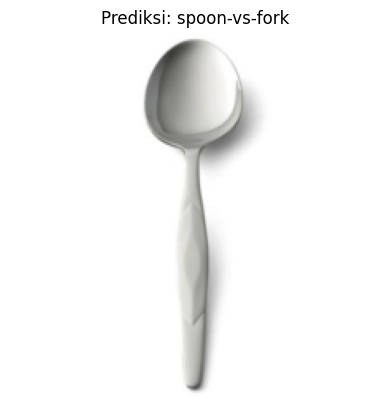

In [14]:
# 6. FUNGSI UNTUK PENGUJIAN SATU GAMBAR
def predict_image(image_path, model, transform, class_names):
    # Load gambar
    image = Image.open(image_path).convert('RGB')

    # Terapkan transformasi yang sama seperti dataset test
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model ke mode evaluasi
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.sigmoid(output).item()
        label = 1 if pred > 0.5 else 0
        confidence = pred if label == 1 else 1 - pred

    print(f"Prediksi: {class_names[label]} (Confidence: {confidence*100:.2f}%)")

    # Tampilkan gambar
    img_show = image_tensor.squeeze().cpu()
    # Un-normalisasi
    img_show = img_show * torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = img_show.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Prediksi: {class_names[label]}")
    plt.axis('off')
    plt.show()

test_image_path = "/kaggle/input/spoonvsfork/spoon-vs-fork/spoon/00000005.jpg"
predict_image(test_image_path, model, test_transform, class_names)